<a href="https://colab.research.google.com/github/sebac820/tarea-1-recsys/blob/main/Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1

## Librerías

Instalar librerías necesarias:

In [2]:
!pip3 install pyreclab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 234 kB 5.3 MB/s 


Importar librerías:

In [7]:
from collections import defaultdict
from math import log2
from pyreclab import BprMf, IFAls
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Enlazar con Google Drive:

In [8]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Actividad 1: Análisis exploratorio

### Visualización de los datos de entrenamiento

Importamos y visualizamos los datos de entrenamiento:

In [63]:
train_set = pd.read_csv(f'{data_path}/transactions_train.csv', header=0, index_col=0)
print(f'El dataset de entrenamiento cuenta con {train_set.shape[0]} filas y {train_set.shape[1]} columnas.')
print('Las primeras cinco filas son:')
train_set.head()

El dataset de entrenamiento cuenta con 1318501 filas y 5 columnas.
Las primeras cinco filas son:


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2


### Distribución del número de compras por usuario

Obtenemos a los 10 usuarios más activos en el dataset:

In [64]:
# Hacemos una copia del set de entrenamiento manteniendo solamente la columna 'customer_id':
compras_por_usuario = train_set.drop(columns=['t_dat', 'article_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'compras':
compras_por_usuario['compras'] = 1
# Agrupamos por 'customer_id' y contamos la cantidad de veces que se repite cada usuario en el set:
compras_por_usuario = compras_por_usuario.groupby('customer_id').count()
# Ordenamos la cuenta de cada usuario de mayor a menor:
compras_por_usuario = compras_por_usuario.sort_values(by='compras', ascending=False)
# Calculamos el porcentaje que representa cada número de compras dentro del dataset:
compras_por_usuario['porcentaje_del_dataset'] = compras_por_usuario / train_set.shape[0] * 100
# Desplegamos el porcentaje total que representa el top 10 dentro del dataset:
porcentaje_total_que_representa_el_top_10 = compras_por_usuario.iloc[0:10].sum()['porcentaje_del_dataset']
print(f'Porcentaje total que representa el top 10 dentro del dataset: {porcentaje_total_que_representa_el_top_10}%')
# Desplegamos el top 10 de usuarios más activos en el set:
display(compras_por_usuario.head(10))

Porcentaje total que representa el top 10 dentro del dataset: 0.6309437763035446%


,compras,porcentaje_del_dataset
customer_id,,
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc,1346,0.102086
84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb050070369176905712,950,0.072052
e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c72774e3f3338cbbb3335e,910,0.069018
2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8b56e5b66c86182bedf,875,0.066363
9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23704f1f654784bcda58,789,0.059841
bbebb44478948f5052c3f4c5dc04f08653e7938886a85685917fd22b92f22cd0,740,0.056124
d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9fd2fedaf1966280943,724,0.054911
ad3090d52d11671ffb43bfaa85e3620eff669e8c92c9114ba7755876254cbba8,670,0.050815
0152d53f51444891ea07013fd1fb8325415bb09bb6798a59359b21a8326d801b,664,0.050360


Así, el top 10 de usuarios con más actividad en el dataset se lleva el 0.6% de las compras, reportando más de 600 compras cada uno. Sin embargo, el resto de usuarios ha realizado una cantidad mucho menor de compras:

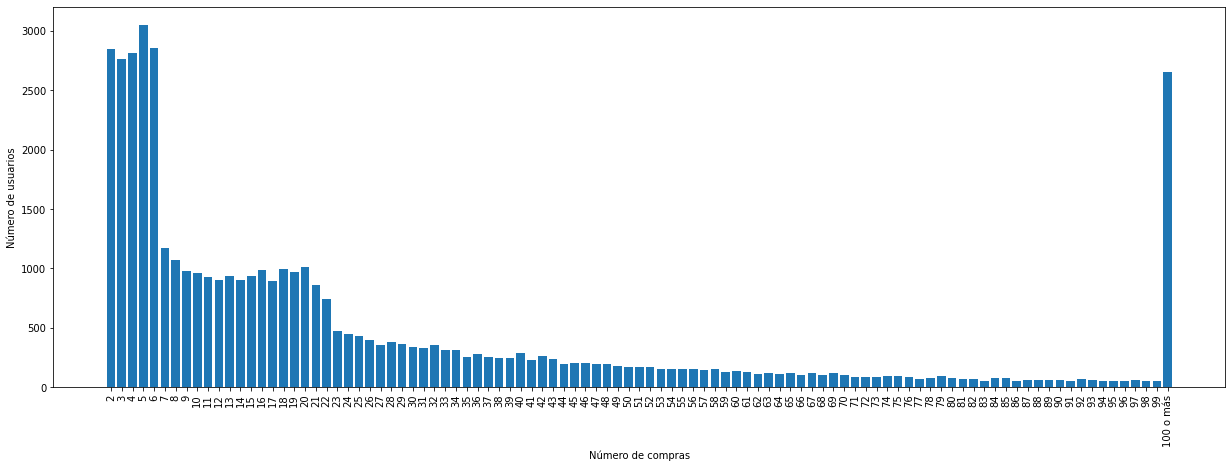

In [65]:
# Hacemos una copia del número de compras por usuario:
usuarios_por_numero_de_compras = compras_por_usuario.drop(columns=['porcentaje_del_dataset'])
# Agregamos una columna 'numero_de_usuarios':
usuarios_por_numero_de_compras['usuarios'] = 1
# Agrupamos por el número de compras, y contamos cuántos usuarios realizaron ese número de compras:
usuarios_por_numero_de_compras = usuarios_por_numero_de_compras.groupby('compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
usuarios_que_realizaron_N_o_mas_compras = usuarios_por_numero_de_compras.loc[N:]['usuarios'].sum()
usuarios_por_numero_de_compras = usuarios_por_numero_de_compras.loc[0:N-1]
usuarios_por_numero_de_compras.loc[f'{N} o más'] = usuarios_que_realizaron_N_o_mas_compras
# Graficamos:
plt.figure(figsize=(21, 7))
plt.xticks(rotation=90)
plt.bar(
    x=[i for i in range(len(usuarios_por_numero_de_compras))],
    height=[usuarios for usuarios in usuarios_por_numero_de_compras['usuarios']],
    tick_label=usuarios_por_numero_de_compras.index,
)
plt.xlabel('Número de compras')
plt.ylabel('Número de usuarios')
plt.show()

Notamos que en la distribución obtenida, la mayor parte de los usuarios han realizado solamente entre 2 a 6 compras, tras lo cual el número de usuarios que ha realizado un mayor número de compras decae rápidamente, asemejándose la curva a un decrecimiento exponencial. 

### Distribución de interacciones por producto

Cargamos los datos de los productos:

In [66]:
productos = pd.read_csv(f'{data_path}/articles.csv', header=0, index_col=0)

Obtenemos los 10 productos más comprados:

In [67]:
# Hacemos una copia del train set, dejando solamente 'article_id':
compras_por_producto = train_set.drop(columns=['t_dat', 'customer_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'compras':
compras_por_producto['compras'] = 1
# Agrupamos por producto y contamos cuántas veces fue comprado cada uno:
compras_por_producto = compras_por_producto.groupby('article_id', as_index=False).sum().sort_values(by='compras', ascending=False).merge(productos, on='article_id')
# Agregamos el porcentaje de las interacciones que representa cada producto:
compras_por_producto['porcentaje_de_interacciones'] = compras_por_producto['compras'] * 100 / train_set.shape[0]
# Calculamos el porcentaje de interacciones del top 10 de productos:
print(f'Los 10 productos más comprados representan el {compras_por_producto["porcentaje_de_interacciones"].head(10).sum()}% de las interacciones en el dataset.')
# Desplegamos los 10 productos más comprados:
compras_por_producto[['article_id', 'prod_name', 'compras', 'porcentaje_de_interacciones']].head(10)


Los 10 productos más comprados representan el 0.8631013552511528% de las interacciones en el dataset.


,article_id,prod_name,compras,porcentaje_de_interacciones
0,706016001,Jade HW Skinny Denim TRS,1978,0.150019
1,706016002,Jade HW Skinny Denim TRS,1357,0.102920
2,610776002,Tilly (1),1302,0.098749
3,372860001,7p Basic Shaftless,1225,0.092909
4,759871002,Tilda tank,1010,0.076602
5,399223001,Curvy Jeggings HW Ankle,991,0.075161
6,464297007,Greta Thong Mynta Low 3p,920,0.069776
7,562245001,Luna skinny RW,899,0.068183
8,562245046,Luna skinny RW,849,0.064391
9,372860002,7p Basic Shaftless,849,0.064391


Así, el top 10 de productos más comprados representan el 0.8% del total de interacciones en el dataset. La distribución de interacciones se observa de la siguiente manera:

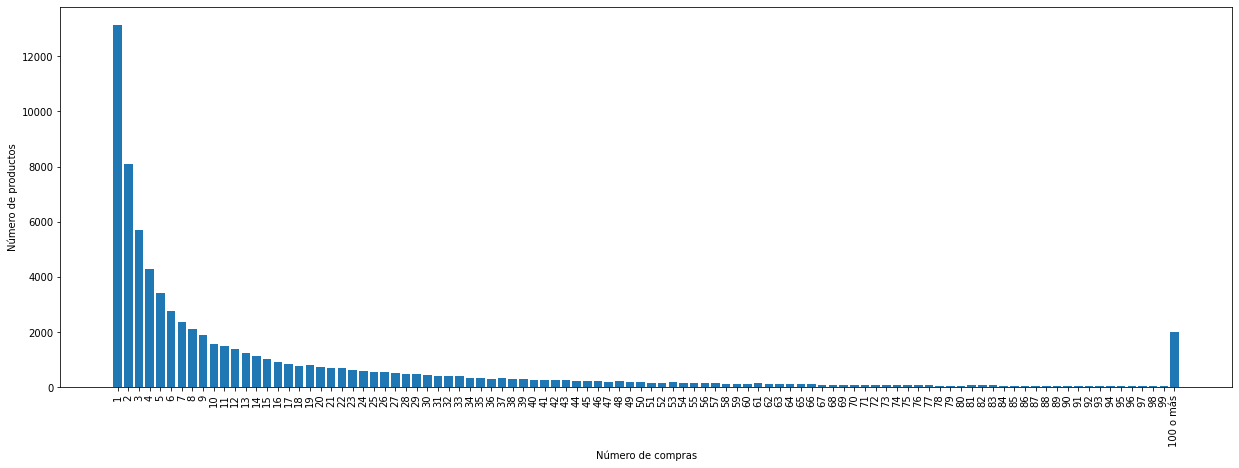

In [68]:
# Creamos una copia de compras_por_producto:
productos_por_numero_de_compras = compras_por_producto[['compras']].copy()
# Agregamos la columna 'productos':
productos_por_numero_de_compras['productos'] = 1
# Agrupamos por número de compras y contamos:
productos_por_numero_de_compras = productos_por_numero_de_compras.groupby('compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
productos_que_fueron_comprados_N_o_mas_veces = productos_por_numero_de_compras.loc[N:]['productos'].sum()
productos_por_numero_de_compras = productos_por_numero_de_compras.loc[0:N-1]
productos_por_numero_de_compras.loc[f'{N} o más'] = productos_que_fueron_comprados_N_o_mas_veces
# Graficamos:
plt.figure(figsize=(21, 7))
plt.xticks(rotation=90)
plt.xlabel('Número de compras')
plt.ylabel('Número de productos')
plt.bar(
    x=[i for i in range(len(productos_por_numero_de_compras))],
    height=[productos for productos in productos_por_numero_de_compras['productos']],
    tick_label=productos_por_numero_de_compras.index,
)
plt.show()

Notamos que la mayor parte de los productos fueron comprados 1, 2 o 3 veces, mientras que el número de productos que fueron comprados una mayor cantidad de veces es cada vez menor, asemejándose la curva a un decrecimiento exponencial.

### Tabla resumen

En el set de entrenamiento encontramos lo siguiente:

In [69]:
# Obtenemos los valores únicos:
valores_unicos = train_set.nunique()
tabla_resumen = pd.DataFrame(index=pd.CategoricalIndex(data=[], name='Variable'), columns=['Valor'])
tabla_resumen.loc['Número de usuarios distintos'] = valores_unicos['customer_id']
tabla_resumen.loc['Número de ítems distintos'] = valores_unicos['article_id']
# Obtenemos el promedio y desviación estándar de productos por usuarios:
tabla_resumen.loc['Promedio de productos por usuario'] = compras_por_usuario['compras'].mean()
tabla_resumen.loc['Desviación estándar de productos por usuario'] = compras_por_usuario['compras'].std()
# Obtenemos el promedio y desviación estándar de usuarios por productos:
tabla_resumen.loc['Promedio de usuarios por producto'] = compras_por_producto['compras'].mean()
tabla_resumen.loc['Desviación estándar de usuarios por producto'] = compras_por_producto['compras'].std()
# Obtenemos la densidad del conjunto de datos, dividiendo la cantidad de pares usuario-producto que sí están dentro del set
# por los pares que no lo están: 
tabla_resumen.loc['Densidad del conjunto de datos en cuanto a compras'] = (
    train_set[['customer_id', 'article_id']].drop_duplicates().shape[0] / (
        train_set['customer_id'].nunique() * train_set['article_id'].nunique()
    )
)
# Visualizamos los resultados:
tabla_resumen


,Valor
Variable,
Número de usuarios distintos,45000
Número de ítems distintos,73080
Promedio de productos por usuario,29.300022
Desviación estándar de productos por usuario,44.939461
Promedio de usuarios por producto,18.041886
Desviación estándar de usuarios por producto,38.01747
Densidad del conjunto de datos en cuanto a compras,0.000342


### Preparaciones para la evaluación de modelos

A continuación se definen funciones que serán de utilidad para evaluar los distintos modelos de recomendación. Primero, definimos la función `get_top_n()` para obtener el top N recomendado a cada usuario:

In [70]:
# Obtenido de la documentación de Surprise: https://surprise.readthedocs.io/en/stable/FAQ.html
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Definimos la función `ndcg()` para obtener las métricas NDCG:

In [71]:
def dcg_para_un_usuario(top_n_verdadero: list, top_n_predicho: list, arroba: int):
    # Definimos limite_del_top_n_verdadero para que no nos arroje un error de "index out of range" al comparar los
    # elementos de top_n_predicho con los de top_n_verdadero:
    limite_del_top_n_verdadero = min(arroba, len(top_n_verdadero))
    # Inicializamos la suma de gains en cero:
    dcg = 0
    # Para cada ítem dentro del límite dado por @...
    for i in range(1, arroba+1):
        item = top_n_predicho[i-1]
        # ... si el item está en el top_n_verdadero, es relevante. Si no, no:
        if item in top_n_verdadero[0:limite_del_top_n_verdadero]:
            relevante = 1
        else:
            relevante = 0
        # Sumamos el gain descontado:
        dcg += (2**relevante - 1) / log2(i + 1)
    # Retornamos el resultado final:
    return dcg

def idcg_para_un_usuario(arroba: int):
    idcg = 0
    for i in range(1, arroba+1):
        # Hacemos que todos los ítems sean relevantes:
        idcg += 1 / log2(i + 1)
    return idcg

def ndcg_para_un_usuario(top_n_verdadero: list, top_n_predicho: list, arroba: int):
    return dcg_para_un_usuario(top_n_verdadero, top_n_predicho, arroba) / idcg_para_un_usuario(arroba)

def ndcg(top_n_verdadero_para_cada_usuario: dict, top_n_predicho_para_cada_usuario: dict, arroba: int):
    suma_de_ndcgs = 0
    for usuario in top_n_verdadero_para_cada_usuario.keys():
        top_n_verdadero = top_n_verdadero_para_cada_usuario[usuario]
        top_n_predicho = top_n_predicho_para_cada_usuario[usuario]
        suma_de_ndcgs += ndcg_para_un_usuario(top_n_verdadero, top_n_predicho, arroba)
    return suma_de_ndcgs / len(top_n_verdadero_para_cada_usuario)

Definimos la función `mean_ap()` para obtener las métricas MAP:

In [72]:
def ap(top_n_verdadero: list, top_n_predicho: list, arroba: int):
    # Definimos limite_del_top_n_verdadero para que no nos arroje un error de "index out of range" al comparar los
    # elementos de top_n_predicho con los de top_n_verdadero:
    limite_del_top_n_verdadero = min(arroba, len(top_n_verdadero))
    verdaderos_positivos_hasta_el_momento = 0
    suma_de_precisiones = 0
    # Para cada ítem dentro del límite dado por @...
    for i in range(1, arroba+1):
        item = top_n_predicho[i-1]
        # ... si el item no está en el top_n_verdadero, no es relevante. Si sí lo está, es relevante:
        if not item in top_n_verdadero[0:limite_del_top_n_verdadero]:
            continue
        verdaderos_positivos_hasta_el_momento += 1
        suma_de_precisiones += verdaderos_positivos_hasta_el_momento / i
    # Retornar precisión promedio:
    if verdaderos_positivos_hasta_el_momento == 0:
        return 0
    return suma_de_precisiones / verdaderos_positivos_hasta_el_momento
    # Fórmula complementada por https://medium.com/@misty.mok/how-mean-average-precision-at-k-map-k-can-be-more-useful-than-other-evaluation-metrics-6881e0ee21a9

def mean_ap(top_n_verdadero_para_cada_usuario: dict, top_n_predicho_para_cada_usuario: dict, arroba: int):
    suma_de_aps = 0
    for usuario in top_n_verdadero_para_cada_usuario.keys():
        suma_de_aps += ap(top_n_verdadero_para_cada_usuario[usuario], top_n_predicho_para_cada_usuario[usuario], arroba)
    return suma_de_aps / len(top_n_verdadero_para_cada_usuario)

Definimos la función `evaluar()` para incorporar las métricas NDCG@10, NDCG@20, NDCG@30, MAP@10, MAP@20 y MAP@30, junto con la función `imprimir_metricas()` para visualizarlas:

In [73]:
def evaluar(top_n_verdadero_para_cada_usuario: dict, top_n_predicho_para_cada_usuario):
    resultados = {'ndcg': {10: None, 20: None, 30: None}, 'map': {10: None, 20: None, 30: None}}
    for arroba in (10, 20, 30):
        resultados['ndcg'][arroba] = ndcg(top_n_verdadero_para_cada_usuario, top_n_predicho_para_cada_usuario, arroba)
        resultados['map'][arroba] = mean_ap(top_n_verdadero_para_cada_usuario, top_n_predicho_para_cada_usuario, arroba)
    return resultados

def imprimir_metricas(metricas: dict):
    # Imprimir métricas:
    for arroba in (10, 20, 30):
        print(f'NDCG@{arroba}:', metricas['ndcg'][arroba])
    for arroba in (10, 20, 30):
        print(f'MAP@{arroba}:', metricas['map'][arroba])

Importamos el dataset de validación:

In [74]:
validation_set = pd.read_csv(f'{data_path}/transactions_val.csv', header=0, index_col=0)
print(f'El dataset de validación cuenta con {validation_set.shape[0]} filas y {validation_set.shape[1]} columnas.')
print('Los usuarios con más compras realizadas en el dataset de validación son:')
validation_set.head()

El dataset de validación cuenta con 140312 filas y 5 columnas.
Los usuarios con más compras realizadas en el dataset de validación son:


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-20,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,535035001,0.118627,2
1,2020-06-15,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...,654046004,0.022017,2
2,2019-10-20,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...,742086008,0.033881,2
3,2020-07-14,3219f007e898957cbe0ff0f22010cd7118c06f7498a167...,778534006,0.042356,1
4,2020-09-07,4e5c03f7ffefe2f99f8e0c9d9805c1571867e6a8dd7091...,706016015,0.033881,1


Finalmente, generamos las recomendaciones "correctas" para cada usuario, considerando como "relevantes" los ítems que compró, e irrelevantes los ítems que no:

In [56]:
top_n_verdadero_para_cada_usuario = defaultdict(list)
for i in validation_set.index:
    fila = validation_set.loc[i]
    top_n_verdadero_para_cada_usuario[fila['customer_id']].append(fila['article_id'])
print('Recomendaciones \"correctas\" para un usuario de ejemplo (ID d265c0dc7e871726894c8a14e2369768af5f5315a55dc822d46e1c1d44d7d89e):')
top_n_verdadero_para_cada_usuario['d265c0dc7e871726894c8a14e2369768af5f5315a55dc822d46e1c1d44d7d89e']

Recomendaciones "correctas" para un usuario de ejemplo (ID d265c0dc7e871726894c8a14e2369768af5f5315a55dc822d46e1c1d44d7d89e):


[808305001,
 808305001,
 764624004,
 803468002,
 803468002,
 857794006,
 916000003,
 916000003,
 926164001,
 935092001]

## Actividad 2: Recomendación no personalizada

### Most Popular

Para la recomendación *most popular*, debemos obtener los 30 productos más vendidos:

In [57]:
top_30_most_popular = np.array(compras_por_producto.sort_values(by='compras', ascending=False)['article_id'][0:30])
print('IDs de los 30 productos más vendidos:')
top_30_most_popular

IDs de los 30 productos más vendidos:


array([706016001, 706016002, 610776002, 372860001, 759871002, 399223001,
       464297007, 562245001, 372860002, 562245046, 351484002, 156231001,
       673396002, 399256001, 706016003, 610776001, 673677002, 573716012,
       720125001, 448509014, 568601006, 160442007, 608776002, 158340001,
       484398001, 688537004, 599580017, 554450001, 565379001, 507909001])

Luego, recomendamos dichos productos a todos los usuarios:

In [58]:
top_30_most_popular_para_cada_usuario = defaultdict(list)
for usuario in validation_set['customer_id'].unique():
    top_30_most_popular_para_cada_usuario[usuario] = top_30_most_popular

Finalmente, obtenemos las métricas de nuestra predicción:

In [59]:
imprimir_metricas(evaluar(top_n_verdadero_para_cada_usuario, top_30_most_popular_para_cada_usuario))

NDCG@10: 0.003007091961237623
NDCG@20: 0.002632137060389783
NDCG@30: 0.0022961592980431
MAP@10: 0.0092845129725025
MAP@20: 0.010244445762779046
MAP@30: 0.010616304990921407


### Random

Para la recomendación *random* seleccionamos 30 productos al azar:

In [60]:
top_30_random = np.array(random.sample(list(train_set['article_id'].unique()), k=30))
print('Los 30 ítems seleccionados aleatoriamente fueron:')
top_30_random

Los 30 ítems seleccionados aleatoriamente fueron:


array([686466004, 678995001, 810419009, 452618001, 699923113, 712261002,
       850581002, 768440001, 784313002, 528028001, 628499007, 880852001,
       797418001, 765367002, 699924025, 713774004, 670953001, 501923003,
       616739001, 811398005, 758840001, 902481001, 674865002, 535478003,
       539878001, 633825003, 549262003, 597510008, 590734002, 640258001])

Recomendamos dichos productos a todos los usuarios:

In [61]:
top_30_random_para_cada_usuario = defaultdict(list)
for usuario in validation_set['customer_id'].unique():
    top_30_random_para_cada_usuario[usuario] = top_30_random

Obtenemos las métricas de nuestra predicción:

In [62]:
imprimir_metricas(evaluar(top_n_verdadero_para_cada_usuario, top_30_random_para_cada_usuario))

NDCG@10: 6.519032611064868e-05
NDCG@20: 5.3766179275059885e-05
NDCG@30: 4.418747265722283e-05
MAP@10: 0.0001485353313029553
MAP@20: 0.000167745141635481
MAP@30: 0.0001732947555401863


## Actividad 3: Recomendación basada en feedback implícito